# 4 GLMのモデル選択 --AICとモデルの予測のよさ--

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set()

In [2]:
d = pd.read_csv("./data/data3a.csv")

In [3]:
# 図4.1 左図の描画
formula_const = "y ~ 1"
model_const = smf.glm(data=d,
                      formula=formula_const,
                      family=sm.families.Poisson())
fit_const = model_const.fit()

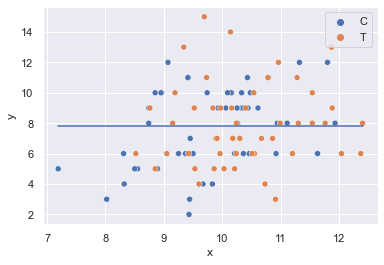

In [4]:
xx = np.linspace(d.x.min(), d.x.max(), 100)
lam = np.exp(fit_const.params['Intercept'])
sns.scatterplot(x='x', y='y', hue='f', data=d)
sns.lineplot(x=xx, y=lam)
plt.show()

In [5]:
# 図4.1 右図の描画
formula_six = "y ~ x + pow(x, 2) + pow(x, 3) + pow(x, 4) + pow(x, 5) + pow(x, 6)"
model_six = smf.glm(data=d,
                    formula=formula_six,
                    family=sm.families.Poisson())
fit_six = model_six.fit()

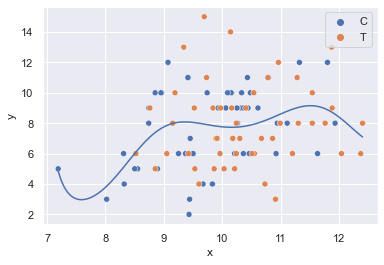

In [6]:
xx = np.linspace(d.x.min(), d.x.max(), 100)
lam = np.exp(fit_six.params['Intercept'] +
             fit_six.params['x'] * xx + fit_six.params['pow(x, 2)'] * xx**2 +
             fit_six.params['pow(x, 3)'] * xx**3 + fit_six.params['pow(x, 4)'] * xx**4 +
             fit_six.params['pow(x, 5)'] * xx**5 + fit_six.params['pow(x, 6)'] * xx**6)
sns.scatterplot(x='x', y='y', hue='f', data=d)
sns.lineplot(x=xx, y=lam)
plt.show()

## 4.1 データはひとつ、モデルはたくさん

In [7]:
# 図4.2の描画
formula_const = "y ~ 1"
model_const = smf.glm(data=d,
                      formula=formula_const,
                      family=sm.families.Poisson())
A = model_const.fit()

formula_f = "y ~ f"
model_f = smf.glm(data=d,
                  formula=formula_f,
                  family=sm.families.Poisson())
B = model_f.fit()

formula_x = "y ~ x"
model_x = smf.glm(data=d,
                  formula=formula_x,
                  family=sm.families.Poisson())
C = model_x.fit()

formula_xf = "y ~ x + f"
model_xf = smf.glm(data=d,
                   formula=formula_xf,
                   family=sm.families.Poisson())
D = model_xf.fit()

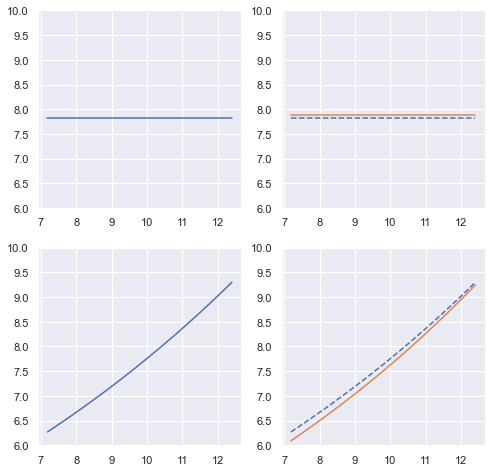

In [8]:
xx = np.linspace(d.x.min(), d.x.max(), 100)
ff = pd.get_dummies(d.f)

plt.figure(figsize=(8, 8))
plt.subplot(221)
lam = np.exp(A.params['Intercept'])
sns.lineplot(x=xx, y=lam)
plt.ylim(6, 10)

plt.subplot(222)
sns.lineplot(x=xx, y=lam, ls='--')
lam = np.exp(B.params['Intercept'] + np.sum(B.params['f[T.T]'] * ff, axis=1))
sns.lineplot(x=xx, y=lam)
plt.ylim(6, 10)

plt.subplot(223)
lam = np.exp(C.params['Intercept'] + C.params['x'] * xx)
sns.lineplot(x=xx, y=lam)
plt.ylim(6, 10)

plt.subplot(224)
sns.lineplot(x=xx, y=lam, ls='--')
lam = np.exp(D.params['Intercept'] + D.params['x'] * xx + np.sum(D.params['f[T.T]'] * ff, axis=1))
sns.lineplot(x=xx, y=lam)
plt.ylim(6, 10)

plt.show()

In [9]:
np.sum(ff * B.params['f[T.T]'], axis=1)

0     0.012772
1     0.012772
2     0.012772
3     0.012772
4     0.012772
        ...   
95    0.012772
96    0.012772
97    0.012772
98    0.012772
99    0.012772
Length: 100, dtype: float64

## 4.2 統計モデルの当てはまりの悪さ：逸脱度

**逸脱度** (deviande) とは、「あてはまりの悪さ」を表現する指標で

$
D = -2 \log L^*
$

と定義される。  
3章3.4.1項で使った平均種子数$\lambda_i$がっ植物の体サイズ$x_i$だけに依存するモデル$\lambda_i=\exp(\beta_1+\beta_2x_2)$を「xモデル」と呼ぶ。このxモデルの最大対数尤度$\log L^*$は-235.4ぐらいであったので、逸脱度($D-2\log L^*$)は470.8ぐらいになる。


In [10]:
formula_x = "y ~ x"
model_x = smf.glm(data=d,
                  formula=formula_x,
                  family=sm.families.Poisson())
fit_x = model_x.fit()

# fitしたモデルのllf属性が log likelihood の値
log_likelihood = fit_x.llf
deviance = -2 * log_likelihood
print("最大対数尤度:", log_likelihood)
print("逸脱度:", deviance)

最大対数尤度: -235.38625076986077
逸脱度: 470.77250153972153


**残差逸脱度** (residuaal deviance)は  
$$D - (ポアソン分布モデルで可能な最小逸脱度)$$  
と定義される。この「ポアソン分布モデルで可能な最小逸脱度」とは、R言語では**フルモデル**(full model)と呼ばれるモデルの逸脱度で、例えば、**データ数が100個**なので**パラメータ100個**を使って「あてはめた」モデルということである。  

In [11]:
# フルモデルの最大対数尤度を求め、最小逸脱度を算出
from scipy.stats import poisson

logL_full = np.sum(np.log(poisson.pmf(d.y, d.y)))
min_deviance = -2 * logL_full
print("フルモデルの最大タイ対数尤度:", logL_full)
print("最小逸脱度:", min_deviance)

フルモデルの最大タイ対数尤度: -192.88975252449595
最小逸脱度: 385.7795050489919


最小逸脱度が得られたので、xモデルの残差逸脱度が求められる。  

In [12]:
# 残差逸脱度
residual_deviance = deviance - min_deviance
print("残差逸脱度:", residual_deviance)

残差逸脱度: 84.99299649072964


In [13]:
# モデルの以下の属性が残差逸脱度に相当する(ごく僅かな誤差はあり)
fit_x.deviance

84.99299649072958

このように残差逸脱度とは、このデータにおいては385.8を基準とする「あてはまりの悪さ」の相対値。統計モデルのパラメータを多くスレb、この残差逸脱度が小さくなるらしいことがわかる。  

残差逸脱度の最大値にいついて考える。  
逸脱度が最大になるのは「最もあてはまりの悪いモデル」の場合である。  
これは切片のみのモデルの場合であり、Rでは"null model"と呼ばれる。  

In [14]:
# 図4.1 左図の描画
formula_null = "y ~ 1"
model_null = smf.glm(data=d,
                formula=formula_null,
                family=sm.families.Poisson())
fit_null = model_null.fit()

In [15]:
# モデルの要約を出力
fit_null.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Wed, 28 Apr 2021   Deviance:                       89.507
Time:                        09:56:45   Pearson chi2:                     87.1
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.000       1.988       2.128
==============================================================================
"""

In [16]:
# 残差逸脱度の最大値
fit_null.deviance

89.50693756958132

In [17]:
# 最大対数尤度
fit_null.llf

-237.6432213092868

In [18]:
# (最大の)逸脱度
max_deviance = -2 * fit_null.llf
print(max_deviance)

475.2864426185736


この最大の逸脱度と、最小の逸脱度の差が89.5ぐらいになる。

In [19]:
max_deviance - min_deviance

89.50693756958168

以上を氷雨にまとめる。

|名前|定義|
|:-|:-|
|逸脱度(D)|$-2 \log L^*$|
|最小の逸脱度|フルモデルをあてはめたときのD|
|残差逸脱度|D-最小のD|
|最大の逸脱度|NullモデルをあてはめたときのD|
|Null逸脱度|最大のD-最小のD|

## 4.3 モデル選択基準AIC

複数の統計モデルの中から、何らかの基準で良いモデルを選択することを**モデル選択**と呼ぶ。  
ここでは、よく使われている**モデル選択基準**の一つ**AIC**(Akaike's Information criterion)を使ったモデル選択を紹介する。  

AICは東映モデルの当てはまりの良さではなく、**予測の良さ**を重視するモデル選択基準である。  

最尤推定したパラメータの個数がkであるときにAICは  

$
\begin{eqnarray}
AIC &=& -2\{ (最大対数尤度) - (最尤推定したパラメータ数) \} \\
    &=& -2(\log L^* - k) \\
    &=& D + 2k
\end{eqnarray}
$

と定義される。このAICが**一番小さいモデルが良いモデル**となる。  

In [20]:
# 一定モデルのAIC
print(A.aic)
# fモデルのAIC
print(B.aic)
# xモデルのAIC
print(C.aic)
# x-fモデルのAIC
print(D.aic)

477.2864426185736
479.2545139213737
474.77250153972153
476.58743848498733


## 4.5 なぜAICでモデル選択してよいのか？

(100, 3)